# Text classification :: Spam detection

## Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

## Data

We will use the [SpamAssassin](https://spamassassin.apache.org/) public email corpus. This dataset contains ~6'000 labeled emails with a ~30% spam ratio. If you want to learn more about this dataset, check [this](https://spamassassin.apache.org/old/publiccorpus/). (*Note: Datasets of text are called corpora and samples are called documents.*) 

The dataset has been downloaded for you and is available in the *data* folder.

## Notebook overview

* Load the data
* Text preprocessing
* Data exploration
* Feature extraction
* Build a spam detector
* What did our model learn? Error analysis

## 1. The data

In [1]:
# Load libraries and helper functions
import tools

In [2]:
# Load the data
df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: label, dtype: float64




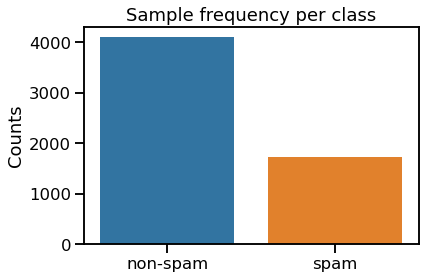

In [4]:
tools.plot_class_frequency(df)

Now, let's have a look at a few rows from the dataset.

***Note:*** The *label* is 0 for *non-spam* and 1 for *spam*.

In [ ]:
# If you rerun this cell then you get a different set of samples displayed
df.sample(3)

## 2. Text preprocessing

Good text preprocessing is an essential part of every NLP project!

Our goal here is to build a model that distinguishes non-spam from spam. The idea here is to "clean" and "standardize" raw text before feeding it to our machine learning model. We need to keep as many "informative" words as possible, while discarding the "uniformative" ones. Removing unnecessary content, i.e. the "noise", from our texts will help to improve the accuracy of our models.

<div class="alert alert-success">
<h2>Questions</h2>
    
Take a few minutes to look at the raw text.
    
**Which parts of the text do you think should be removed to make it readable?**
    
**How could the parts we have removed be useful for the distinction of spam and non-spam?**
</div>

A few observations:

* HTML tags 
* URLs
* E-mail addresses
* Punctuation marks, digits (e.g. 2002, 1.1, ...)
* Multiple whitespace
* Case conversion (e.g. Dog vs dog, ...)
* English STOPWORDS (e.g. a, is, my, i, all, and, by...)
* ...

Check out the features created in the subsection **Spammish signatures** that account the number of occurences with in an email, e.g. how many HTML tags or URLs did find in the email.

The *clean_corpus* function below takes care of all of that!

In [5]:
df = tools.clean_corpus(df)

print("Data cleaned")

Data cleaned


Let's have a look at a few "cleaned" examples.

In [7]:
tools.show_clean_text(df)


Original document:

BAD MSG: > And you get a working version of your favourite KDE/Gnome desktop > > instead of DTE,
uhm, I mean CDE. > > um.. http://wwws.sun.com/software/star/gnome/ integrated into solaris. Yeah
yeah yeah. I tried it (over a year ago) and it sucked like a new vacuum cleaner. Although I expect
that it will be a lot better by now. What I would really like to see is Gnome on one of the Sun Ray
thin terminals. > Out of curiosity, does `normal fashion` mean that you still have to do the >
interactive customisations or is it like Solaris jumpstart where you can > specify everything on the
install server, do `boot net - install` go home, and > come in to a fully installed and patched
desktop the next morning? Er, I mean normal fashion for a Linux install. This would be distro
specific, anyway. I am sure it would be possible to do an automated install with a few script
changes. I would not be surprised if Debian does this already. I do know that if you pass extra
parameters

## 3. Data Exploration :: What makes spam distinct?

### 2.1 Frequent words

Which words distinguish spam from non-spam? Can we  identify the words in a text that are the most informative about its topic?

Let's find the most frequent words in spam and non-spam.

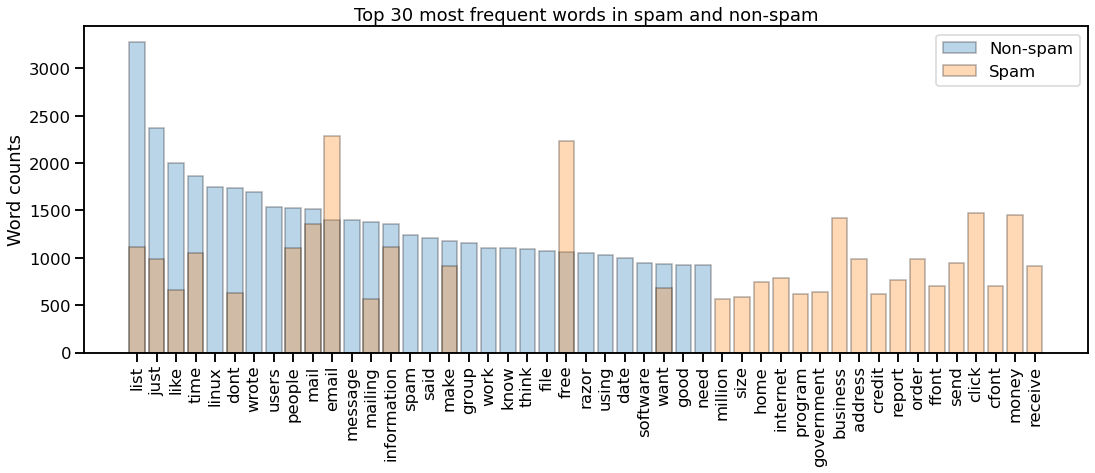

In [7]:
tools.plot_most_common_words(df=df, N=30)

<div class="alert alert-success">
<h3>Task 1</h3>
    
Change `N=30` and compare the outcome.
</div>

**Frequent "spammish" words**: 

* click
* money
* business
* free
* email
* ...

**Frequent "non-spammish" words**:
* list
* linux
* message
* wrote
* users
* spam
* said
* file
* good
* ...

### 2.2 What about "spammish" signatures?

* Do spams contain more HTML tags? 
* Does non-spam contain more URLs and E-mail adresses? 
* Are spams mails longer than non-spam? 
* ...

Let's find out!

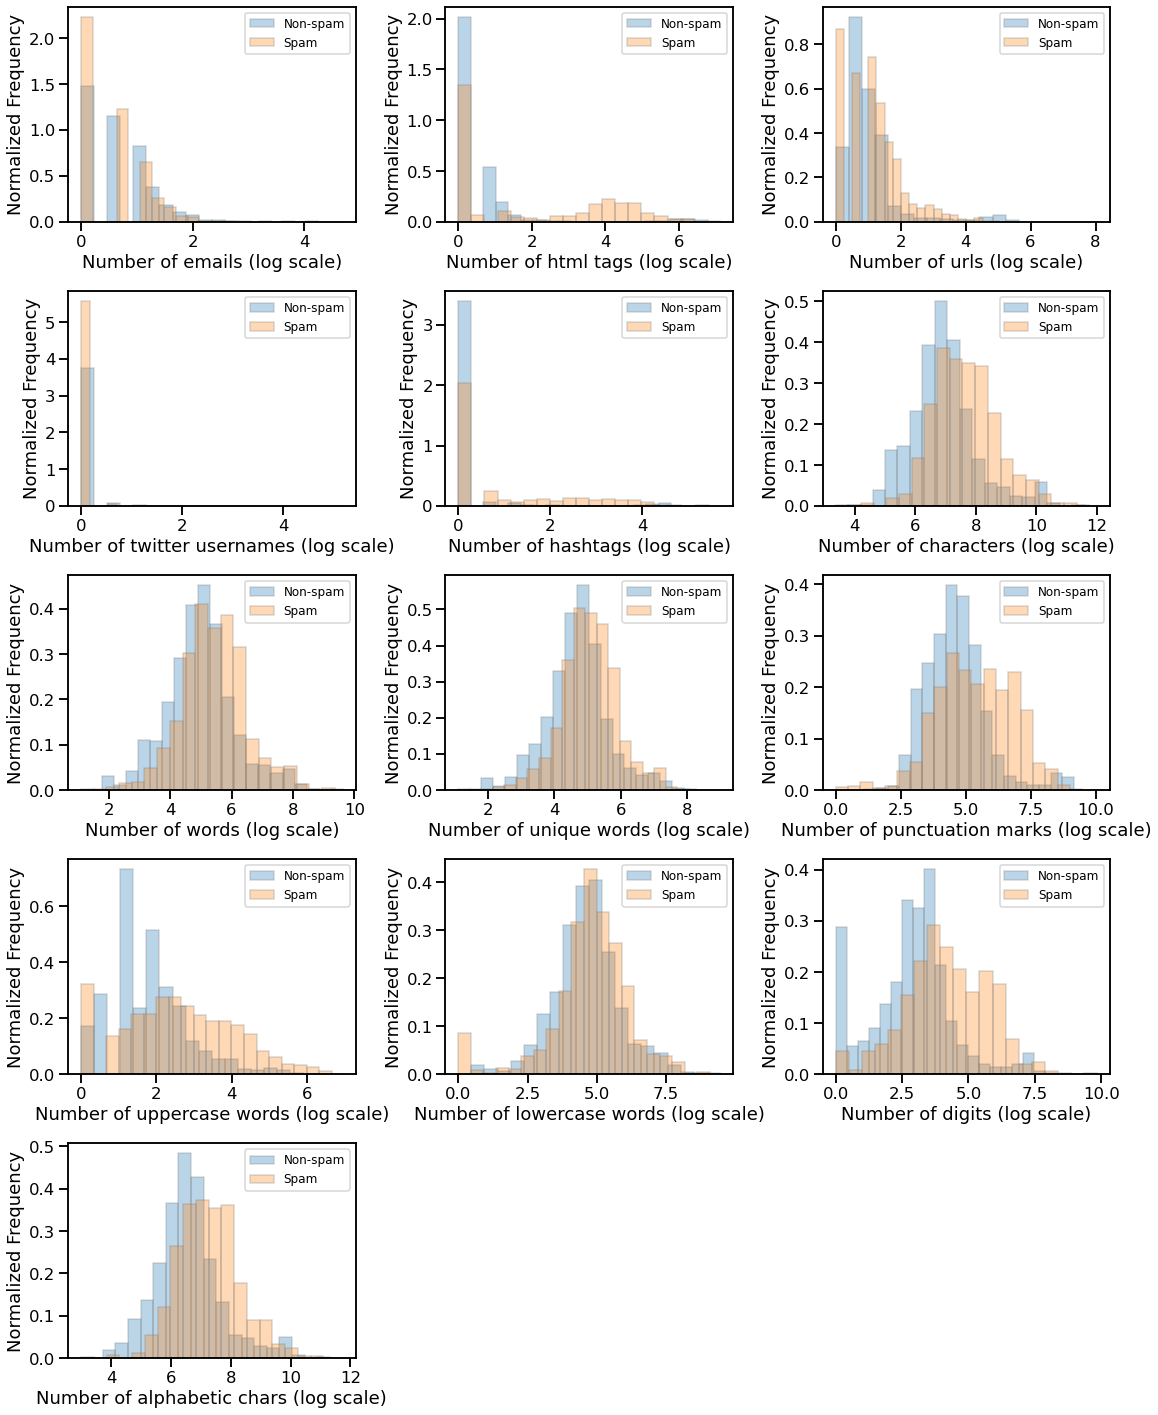

In [8]:
features = tools.get_features(df=df)

## 3. Feature engineering :: Extracting features from text

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the structure of the input text (word order, chapters, paragraphs, sentences and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurencies leads to the mental image of representing text as a "bag".  

**Example:** Let our toy corpus contain four documents.

$ corpus = ['I\;enjoy\;paragliding.',  $  
$\hspace{2cm}'I\;like\;NLP.',$  
$\hspace{2cm}'I\;like\;deep\;learning.',$  
$\hspace{2cm}'O\;Captain!\;my\;Captain!']$ 

In [9]:
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words has converted all documents into numeric vectors. Each column represents a word from the corpus and each row one of the four documents. The value in each cell represents the number of times that word appears in a specific document. For example, the fourth document has the word `captain` occuring twice and the words `my` and `O` occuring once.

## 4. Build a spam detector

In the previous section, we saw how to perform text preprocessing and feature extraction from text. We are now ready to build our machine learning model for detecting spams. We will use a Logistic Regression classifier ([online documentation](https://en.wikipedia.org/wiki/Logistic_regression)).

First, we need to split the data into two sets: the `train` set and the `test` set. We will then use the train set to `fit` our model. The test set will be used to `evaluate` the performance of our model. 

### 4.1 Spam classification

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

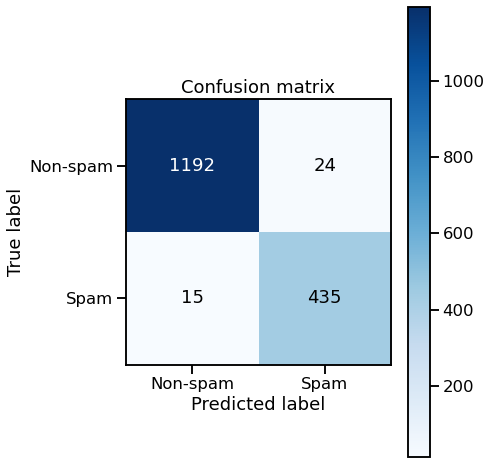

In [10]:
# Train/test splitting
df_train, df_test = tools.train_test_split_(df)

# Fit model on the train data
model = tools.fit_model(df_train)

# Print predictions on test set
tools.plot_confusion_matrix(df_test, model)

**Confusion matrices**  

Confusion matrices are a nice way of evaluating the performance of models for classification models. Rows correspond to the true classes and the columns to the predicted classes. Entries on the main diagonal of the confusion matrix correspond to correct predictions while the other cells tell us how many mistakes made our model ([online documentation]((https://en.wikipedia.org/wiki/Confusion_matrix))).

* The first row represents non-spam mails: 1'187 were correctly classified as 'non-spam', while 29 (~2,3%) were misclassified as 'spam'.
* The second row represents spam mails: 437 were correctly classified as 'spam', while 13 (~2,8%) were misclassified as 'non-spam'.

Our model did quite well!

### 4.2 What did our model learn from the data?

Our logistic regression model has learned which words are the most indicative of non-spam and which words are the most indicative of spam. The positive coefficients on the right correspond to words that, according to the model, are indicative of spam. The negative coefficients on the left correspond to words that, according to the model, are indicative of non-spam.

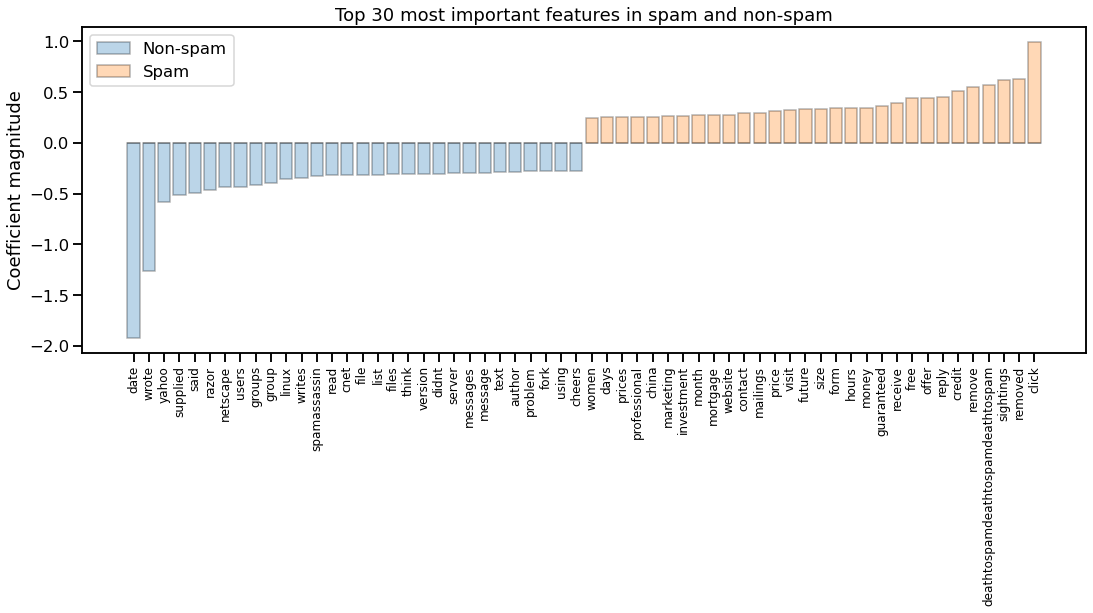

In [11]:
tools.visualize_coefficients(model, n_top_features=30)

According to the model, words such as "date", "wrote", "yahoo", "said", "linux", "author", ... are strong indicators of non-spam.  

Words such as "click", "credit", "remove", "free", "offer", "money" ... indicate spam. 

### 4.3 Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

Document index: 16 


Original Text
<html><body> <center> <font face="arial"><b>Talk on Tele with locals in your area who want to meet
for real encounters. No pre recorded bull this is the real deal. <p> US residents: the 9<!--dads
tools-->00-370-54<!--starter-->65 or 8<!--ender-->88-400-1<!--end-->919. - 99<!--hi hi --> cents /
min <p> For CA callers try our special California line, California is so popular we had to create a
seperate system just for them <p> : 1-<!--moms-->9<!--low-->00-505-7575. <p> must be 18<!--none-->+
be careful when making sexual dates and meetings. Cali 9<!--polic cars-->00# is $1.99 per min
</html> 211075433222 


Cleaned text
talk tele locals area want meet real encounters recorded bull real deal residents cents callers
special california line california popular create seperate just careful making sexual dates meetings
cali 


Actual class:     Spam
Predicted class:  Non-spam 


Predicted probabilities

Non-spam:   0.5239
Spam:       0.4761



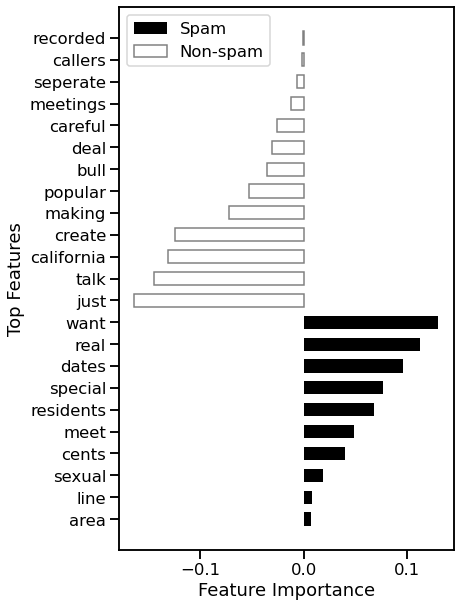

In [14]:
tools.error_analysis(df_test, model, doc_nbr=16)

<div class="alert alert-success">
<h3>Task 2</h3>
    
Let's change the `doc_nbr`.
</div>